# [HW11] Multiple Linear Regression

지난시간에는 하나의 독립 변수 $x$에 대해서 하나의 종속 변수 $y$ 사이의 관계를 알아보는 simple linear regression에 대해서 실습했습니다. 하지만 실제로 예측을 하고자 할 떄 보통 하나 이상의 변수들을 고려해야 합니다. 예를 들어서 집 값을 예측을 하고자 한다면, 집의 크기, 주변의 편의 시설, 위치, 화장실의 개수, 건축 년도 등등 고려해야 할 것들이 매우 많습니다. 이번 과제에서는 이렇게 다양한 입력 변수들을 다루는 **multiple linear regression** 에 대해서 알아보겠습니다. 

##  1.1 Dataset

Multiple linear regression을 진행하기 위해서 데이터셋을 가져오겠습니다. 이번 과제에서 사용할 데이터셋은 자동차의 여러 기술적인 사양들을 고려하여 연비를 예측하는 auto miles per gallon(MPG) dataset입니다. 


데이터를 불러오겠습니다. 

In [11]:
import pandas
import seaborn
seaborn.set()

In [12]:
from urllib.request import urlretrieve
URL = 'https://go.gwu.edu/engcomp6data3'
urlretrieve(URL, 'auto_mpg.csv')

('auto_mpg.csv', <http.client.HTTPMessage at 0x7f8173f55310>)

In [3]:
mpg_data = pandas.read_csv('auto_mpg.csv')
mpg_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


mpg_data.info()를 통해서 Data에 대한 정보를 살펴보겠습니다. 

In [4]:
mpg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    float64
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car name      392 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 27.7+ KB


총 392개의 데이터가 있고 9개의 정보들이 있습니다. 

여기서 car name 은 object로 자동차의 이름을 담고 있습니다. 

그리고 origin은 int로 정수 형태이지만 이것이 만들어진 도시로 categorical 한 값입니다(ex. 서울 : 1, 경기 : 2, ... ). 

그렇기 때문에 이번에 linear regression을 할 때는 car name, origin 값은 제외하고 생각하도록 하겠습니다. 

In [5]:
y_col = 'mpg'
x_cols = mpg_data.columns.drop(['car name', 'origin', 'mpg'])  # also drop mpg column

print(x_cols)

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model year'],
      dtype='object')


## 1.2 Data exploration

먼저 linear regression을 진행하기 전에 자동차의 정보들과 연비와의 1대1 상관관계를 알아보겠습니다. 

시각화해서 보는 것이 가장 직관적으로 이해하기 쉽습니다. 

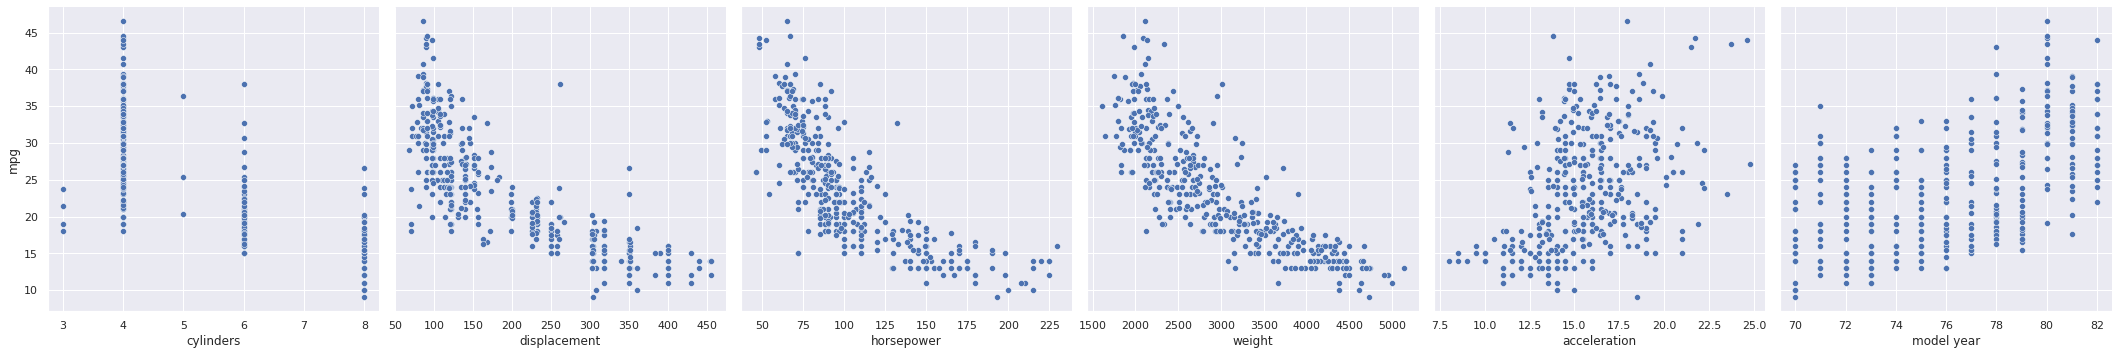

In [6]:
seaborn.pairplot(data=mpg_data, height=5, aspect=1,
             x_vars=x_cols,
             y_vars=y_col);

Accerlation과 model_year 의 정보는 양의 상관관계에 있고 나머지는 음의 상관관계에 있습니다. 

이러한 상관관계를 통해서 linear model 이 연비를 예측하는데 충분하다는 것을 알 수 있습니다.

## 1.3 Linear model in matrix form

Multiple linear regression 에서 입력 변수가 $d$개라고 하면 우리가 찾아야 하는 model은 다음과 같습니다. 
$$\hat{y} = w_0 + w_1x_1 + w_2x_2 + ... + w_dx_d$$
여기서 $\hat{y}$는 우리가 예측한 값입니다. 여기서 편의를 위해 $x_0=1$ 를 추가해서 위 식을 정리하면 다음과 같게 됩니다. 
$$\hat{y} = \sum_{i=0}^d w_ix_i = \mathbf{x}^\top \mathbf{w}$$
여기서 $\mathbf{x} = (x_0, x_1, ... , x_d)$로 입력 변수들로 이루어진 벡터이고  $\mathbf{w} = (w_0, w_1, ... , w_d)$로 입력 변수에 곱해지는 계수들로 이루어진 벡터입니다. 

이제 우리는 392개의 데이터를 가지고 있습니다. 이를 $N$개라고 생각하고 식을 나열해보면 다음과 같습니다. 
$$\hat{y}^{(1)} = w_0x_0^{(1)} + w_1x_1^{(1)} + w_2x_2^{(1)} + ... + w_dx_d^{(1)}$$
$$\hat{y}^{(2)} = w_0x_0^{(2)} + w_1x_1^{(2)} + w_2x_2^{(2)} + ... + w_dx_d^{(2)}$$
$$\vdots$$
$$\hat{y}^{(N)} = w_0x_0^{(N)} + w_1x_1^{(N)} + w_2x_2^{(N)} + ... + w_dx_d^{(N)}$$
이제 최종적으로 위의 식을 한번에 행렬의 형태로 표현하면 다음과 같습니다. 

$$\hat{\mathbf{y}} = \begin{bmatrix}
\hat{y}^{(1)}  \\
\hat{y}^{(2)}\\
\vdots  \\
\hat{y}^{(N)}
\end{bmatrix} =
\begin{bmatrix}
x_0^{(1)} &  x_1^{(1)} & \cdots & x_d^{(1)} \\
x_0^{(2)} &  x_1^{(2)} & \cdots & x_d^{(2)} \\
\vdots & \vdots & \ddots & \vdots \\
x_0^{(N)} &  x_1^{(N)} & \cdots & x_d^{(N)}
\end{bmatrix} \begin{bmatrix}
w_0  \\
w_1\\
\vdots  \\
w_d 
\end{bmatrix} 
= \mathbf{X}\mathbf{w}$$

여기서 $\mathbf{x}$ 는 입력 변수들을 행렬의 형태로 나타낸 것입니다. 그리고 맨 앞에 $x_0 = 1$을 추가했었기 때문에 $\mathbf{X}$의 맨 왼쪽 행렬은 1로 이루어져 있습니다. 

그리고 $\hat{\mathbf{y}}$는 예측한 변수들을 모아놓은 벡터이고, $\mathbf{y}$는 실제 연비들을 모아놓은 벡터입니다. 

이제 이것들을 코드로 표현해 보겠습니다. 

In [13]:
from autograd import numpy
from autograd import grad

In [15]:
X = mpg_data[x_cols].values
X = numpy.hstack((numpy.ones((X.shape[0], 1)), X))  # pad 1s to the left of input matrix
y = mpg_data[y_col].values

print("X.shape = {}, y.shape = {}".format(X.shape, y.shape))

X.shape = (392, 7), y.shape = (392,)


이제 cost function을 정의해보겠습니다. [HW10]에서 했던 것처럼 mean squared error 를 사용하겠습니다. 

$$L(\mathbf{y}, \hat{\mathbf{y}}) = \frac{1}{N} \sum_{i=1}^N (y^{(i)} - \hat{y}^{(i)})^2$$

Cost function과 우리의 linear regression model을 코드로 나타내면 다음과 같습니다. 

In [16]:
def linear_regression(params, X):
    '''
    The linear regression model in matrix form.
    Arguments:
      params: 1D array of weights for the linear model
      X     : 2D array of input values
    Returns:
      1D array of predicted values
    '''
    return numpy.dot(X, params)

def cost_function(params, model, X, y):
    '''
    The mean squared error loss function.
    Arguments:
      params: 1D array of weights for the linear model
      model : function for the linear regression model
      X     : 2D array of input values
      y     : 1D array of predicted values
    Returns:
      float, mean squared error
    '''
    y_pred = model(params, X)
    return numpy.mean( numpy.sum((y-y_pred)**2) )

## 1.4 Find the weights using gradient descent

이제 Gradient descent로 cost function을 최소로 해주는 계수를 찾아보겠습니다. autograd.grad()함수로 기울기를 구해서 사용하겠습니다. 

In [17]:
gradient = grad(cost_function)

기울기값이 잘 구해지는지 랜덤한 값을 통해 알아보겠습니다. 

In [18]:
gradient(numpy.random.rand(X.shape[1]), linear_regression, X, y)

array([1.86607454e+06, 1.10131487e+07, 4.13958940e+08, 2.12479430e+08,
       6.00003762e+09, 2.83881725e+07, 1.41181459e+08])

기울기 값이 매우 크게 나오는 것을 알 수 있습니다. 한번 gradient descent를 진행해보겠습니다. 

In [20]:
max_iter = 30
alpha = 0.001
params = numpy.zeros(X.shape[1])

for i in range(max_iter):
    descent = gradient(params, linear_regression, X, y)
    params = params - descent * alpha
    loss = cost_function(params, linear_regression, X, y)
    if i%5 == 0:
        print("iteration {}, loss = {}".format(i, loss))

iteration 0, loss = 9.668521029386562e+18
iteration 5, loss = 5.933187473385039e+87
iteration 10, loss = 3.6409616934209154e+156
iteration 15, loss = 2.234313699411096e+225
iteration 20, loss = 1.37110964841974e+294
iteration 25, loss = inf


/tmp/ipykernel_741/3134771538.py:24: RuntimeWarning: overflow encountered in square
  return numpy.mean( numpy.sum((y-y_pred)**2) )


loss가 무한대를 넘어가서 오류가 발생한 것을 알 수 있습니다. 이런 일이 왜 일어난 것일까요? 

## 1.5 Feature scaling

Gradient descent를 진행했더니 loss가 무한대로 발산했습니다. 이것은 입력 변수들 중에 특정 값들이 너무 커서 일어난 일입니다. 입력 데이터들의 max 와 min 값을 한번 출력해보겠습니다. 

In [21]:
mpg_data[x_cols].describe().loc[['max', 'min']]

,cylinders,displacement,horsepower,weight,acceleration,model year
max,8.0,455.0,230.0,5140.0,24.8,82.0
min,3.0,68.0,46.0,1613.0,8.0,70.0


weight 값을 보면 다른 값들에 비해 매우 큰 것을 알 수 있습니다. 그래서 우리는 값들을 비슷한 크기를 가지도록 바꿔줄 필요가 있습니다. 이번에 사용할 방법은 min-max scaling으로 모든 데이터의 범위를 최대 1, 최소 0으로 맞춰줍니다. 변환하는 식은 다음과 같습니다. 

$$x' = \frac{x - \min(x)}{\max(x)-\min(x)}$$

우리는 이 normalization을 scikit-learn이라는 패키지를 이용해서 하도록 하겠습니다. 

In [22]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(mpg_data[x_cols])
X_scaled = numpy.hstack((numpy.ones((X_scaled.shape[0], 1)), X_scaled)) 

pandas.DataFrame(X_scaled).describe().loc[['max', 'min']]

,0,1,2,3,4,5,6
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0


0번째 행은 처음에 1을 추가해준 행이므로 1로 유지되는게 맞습니다. 이제 변화된 데이터로 다시 gradient descent를 진행해 보겠습니다. 

In [23]:
max_iter = 1000
alpha = 0.001
params = numpy.zeros(X.shape[1])

for i in range(max_iter):
    descent = gradient(params, linear_regression, X_scaled, y)
    params = params - descent * alpha
    loss = cost_function(params, linear_regression, X_scaled, y)
    if i%100 == 0:
        print("iteration {}, loss = {}".format(i, loss))

iteration 0, loss = 116081.11124253299
iteration 100, loss = 5035.737208606848
iteration 200, loss = 4694.653830594689
iteration 300, loss = 4613.631473760374
iteration 400, loss = 4583.327630964672
iteration 500, loss = 4568.155268087918
iteration 600, loss = 4559.2685938773875
iteration 700, loss = 4553.692765631067
iteration 800, loss = 4550.09985725416
iteration 900, loss = 4547.761957132872


params가 학습 완료되었습니다. 학습된 params는 다음과 같고, 우리는 예측 값을 params와 $\mathbf{X}$의 곱으로 나타낼 수 있습니다. 

In [24]:
params

array([ 27.56342896,  -1.24000064,   1.70706502,  -0.2853682 ,
       -23.08358717,   1.06664226,   8.99271696])

In [25]:
y_pred_gd = X_scaled @ params

## 1.6 How accurate is the model?

이제 우리가 만든 모델이 얼마나 정확한지 알아보도록 하겠습니다. Regression 문제에서는 주로 두개의 기본 지표가 있습니다. Mean absolute error(MAE)와 root mean squared error(RMSE)입니다. 두개의 식은 다음과 같습니다.

$$\text{MAE}(\mathbf{y}, \hat{\mathbf{y}}) = \frac{1}{N} \sum_{i=1}^N \left\vert y^{(i)} - \hat{y}^{(i)}\right\vert$$
$$\text{RMSE}(\mathbf{y}, \hat{\mathbf{y}}) =\sqrt{ \frac{1}{N} \sum_{i=1}^N (y^{(i)} - \hat{y}^{(i)})^2}$$

이 지표들도 scikit-learn 패키지를 통해서 사용해보겠습니다. 

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y, y_pred_gd)
rmse = mean_squared_error(y, y_pred_gd, squared=False)
print("mae  = {}".format(mae))
print("rmse = {}".format(rmse))

mae  = 2.6139916011560445
rmse = 3.4055205674118403


## 2. Gradient descent land global temperature anomaly dataset

먼저 어제 사용한 Dataset을 다시 불러오겠습니다. 

In [27]:
from urllib.request import urlretrieve
URL = 'http://go.gwu.edu/engcomp1data5?accessType=DOWNLOAD'
urlretrieve(URL, 'land_global_temperature_anomaly-1880-2016.csv')

('land_global_temperature_anomaly-1880-2016.csv',
 <http.client.HTTPMessage at 0x7f8173bd1220>)

In [28]:
import numpy
import sympy

In [29]:
fname = 'land_global_temperature_anomaly-1880-2016.csv'

year, temp_anomaly = numpy.loadtxt(fname, delimiter=',', skiprows=5, unpack=True)

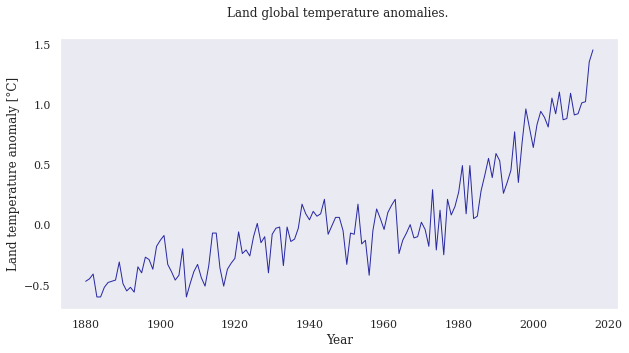

In [30]:
from matplotlib import pyplot
%matplotlib inline

pyplot.rc('font', family='serif', size='18')

#You can set the size of the figure by doing:
pyplot.figure(figsize=(10,5))

#Plotting
pyplot.plot(year, temp_anomaly, color='#2929a3', linestyle='-', linewidth=1) 
pyplot.title('Land global temperature anomalies. \n')
pyplot.xlabel('Year')
pyplot.ylabel('Land temperature anomaly [°C]')
pyplot.grid();

어제는 직접 계산을 하는 방법으로 linear regression을 진행하였습니다. 이번에는 gradient descent 방법으로 해보겠습니다. 

Linear regression 를 하기 위해서 먼저 직선을 정의합니다. 

$$f(x_i) = wx + b$$

그 다음 수업 시간에 배운 cost function을 정의하도록 하겠습니다. 우리가 최소화 해야 할 cost function은 다음과 같습니다. 

$$\frac{1}{n} \sum_{i=1}^n (y_i - f(x_i))^2 = \frac{1}{n} \sum_{i=1}^n (y_i - (wx_i + b))^2$$

이제 코드를 통해 접근해 보도록 하겠습니다.

먼저 cost function을 정의해보겠습니다. 

In [35]:
w, b, x, y = sympy.symbols('w b x y')

cost_function = (w*x + b - y)**2
cost_function     

(b + w*x - y)**2

In [36]:
grad_b = sympy.lambdify([w,b,x,y], cost_function.diff(b), 'numpy')
grad_w = sympy.lambdify([w,b,x,y], cost_function.diff(w), 'numpy')

In [37]:
w = 0
b = 0

for i in range(1000):
    descent_b = numpy.sum(grad_b(w,b,year,temp_anomaly))/len(year)
    descent_w = numpy.sum(grad_w(w,b,year,temp_anomaly))/len(year)
    w = w - descent_w*0.001 # with 0.01 the step size
    b = b - descent_b*0.001 

print(w)
print(b)

nan
nan


<lambdifygenerated-4>:2: RuntimeWarning: overflow encountered in multiply
  return 2*x*(b + w*x - y)
/tmp/ipykernel_741/3139723354.py:7: RuntimeWarning: invalid value encountered in double_scalars
  w = w - descent_w*0.001 # with 0.01 the step size


이번에도 발산하였습니다. 이것도 위의 예시와 같이 우리가 예측해야할 값의 범위와 우리의 입력 변수의 값의 범위가 많이 차이나서 일어난 일입니다. 그래서 normalization을 진행하여 다시 해보겠습니다. 이번에는 Z-Score normalization을 사용하겠습니다. 식은 다음과 같습니다. 

$$x' = \frac{x - \text{mean}(x)}{\text{std}(x)}$$

여기서 mean 은 평균이고 std는 표준 편차입니다. 코드로 표현해보겠습니다. 

In [38]:
year_scaled = (year - year.mean())/year.std()
temp_anomaly_scaled = (temp_anomaly - temp_anomaly.mean()) / temp_anomaly.std()

이게 다시 gradient descent 를 진행해보겠습니다. 

In [39]:
w = 0
b = 0

for i in range(1000):
    descent_b = numpy.sum(grad_b(w,b,year_scaled,temp_anomaly_scaled))/len(year_scaled)
    descent_w = numpy.sum(grad_w(w,b,year_scaled,temp_anomaly_scaled))/len(year_scaled)
    w = w - descent_w*0.001 # with 0.01 the step size
    b = b - descent_b*0.001 

print(w)
print(b)

0.756766964479979
5.551763428541569e-17


$w$ 와 $b$ 를 모두 구했습니다. 이제 그래프로 표현해보겠습니다. 

In [40]:
reg = b + w * year_scaled

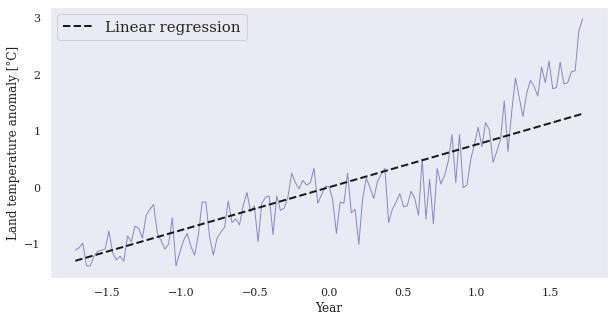

In [41]:
pyplot.figure(figsize=(10, 5))

pyplot.plot(year_scaled, temp_anomaly_scaled, color='#2929a3', linestyle='-', linewidth=1, alpha=0.5) 
pyplot.plot(year_scaled, reg, 'k--', linewidth=2, label='Linear regression')
pyplot.xlabel('Year')
pyplot.ylabel('Land temperature anomaly [°C]')
pyplot.legend(loc='best', fontsize=15)
pyplot.grid();

오늘은 multiple linear regression을 실습을 통해서 배워보았습니다. Feature scaling(normalization)의 중요성을 실습을 진행하면서 알아보고 개선해보았습니다. 

수고하셨습니다~ 질문 있으면 편하게 해주세요~